# Sentiment Classification with Logistic Regression and LSTM

This notebook implements a sentiment analysis system using Logistic Regression and LSTM on a movie review dataset. It includes data loading, preprocessing, model training, hyperparameter tuning, model saving, and a prediction function for user input. Experiment tables capture variations in parameters like learning rate, batch size, optimizer, and feature engineering.

# Sentiment Analysis - Group Assignment
## Group 1 Members:

*   Humphrey Jones Gabarinocheka Nyahoja

*   Samuel Dushime

*   Audry Ashleen Chivanga

*   Jules Gatete


## Step 1: Import Libraries

Install and import necessary libraries for data processing, modeling, and evaluation.

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
import nltk
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samenergy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/samenergy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Step 2: Load and Preprocess Data

Load the dataset from `IMDB Dataset.csv` and clean the text by removing HTML tags, punctuation, and stopwords.

In [16]:
# Load data
df = pd.read_csv('/Users/samenergy/Documents/Projects/alu-ml_tech1-assignment/Dataset/IMDB Dataset.csv')
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Text cleaning function
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Lowercase
    tokens = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning
df['clean_review'] = df['review'].apply(clean_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['sentiment'], test_size=0.2, random_state=42)
print('Training set size:', len(X_train))
print('Test set size:', len(X_test))

Training set size: 40000
Test set size: 10000


## Step 3: Feature Engineering

Prepare features for Logistic Regression (TF-IDF and Count Vectorizer) and LSTM (tokenization and padding).

In [17]:
# TF-IDF for Logistic Regression
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Count Vectorizer as alternative
count_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Tokenization and padding for LSTM
max_words = 10000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

## Step 4: Logistic Regression Training and Tuning

Train Logistic Regression with different hyperparameters (C, solver, vectorizer) and save the best model.

In [18]:
# Logistic Regression function
def train_logistic_regression(X_train, y_train, X_test, y_test, C, solver, vectorizer_type):
    model = LogisticRegression(C=C, solver=solver, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'C': C,
        'solver': solver,
        'vectorizer': vectorizer_type,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'model': model
    }

# Experiments
logistic_experiments = [
    {'C': 0.1, 'solver': 'liblinear', 'vectorizer': 'TF-IDF'},
    {'C': 1.0, 'solver': 'liblinear', 'vectorizer': 'TF-IDF'},
    {'C': 1.0, 'solver': 'saga', 'vectorizer': 'TF-IDF'},
    {'C': 0.1, 'solver': 'liblinear', 'vectorizer': 'Count'},
    {'C': 1.0, 'solver': 'liblinear', 'vectorizer': 'Count'}
]
logistic_results = []
best_logistic_model = None
best_logistic_f1 = 0
best_vectorizer = None

for params in logistic_experiments:
    X_train_vec = X_train_tfidf if params['vectorizer'] == 'TF-IDF' else X_train_count
    X_test_vec = X_test_tfidf if params['vectorizer'] == 'TF-IDF' else X_test_count
    result = train_logistic_regression(X_train_vec, y_train, X_test_vec, y_test, params['C'], params['solver'], params['vectorizer'])
    logistic_results.append({k: v for k, v in result.items() if k != 'model'})
    if result['f1'] > best_logistic_f1:
        best_logistic_f1 = result['f1']
        best_logistic_model = result['model']
        best_vectorizer = tfidf_vectorizer if params['vectorizer'] == 'TF-IDF' else count_vectorizer

# Save best model and vectorizer
joblib.dump(best_logistic_model, 'best_logistic_model.pkl')
joblib.dump(best_vectorizer, 'vectorizer.pkl')

# Display results
print('Logistic Regression Results:')
print(pd.DataFrame(logistic_results)[['vectorizer', 'C', 'solver', 'accuracy', 'precision', 'recall', 'f1']])

Logistic Regression Results:
  vectorizer    C     solver  accuracy  precision    recall        f1
0     TF-IDF  0.1  liblinear    0.8750   0.861477  0.896011  0.878405
1     TF-IDF  1.0  liblinear    0.8949   0.885240  0.909307  0.897112
2     TF-IDF  1.0       saga    0.8949   0.885240  0.909307  0.897112
3      Count  0.1  liblinear    0.8910   0.885268  0.900377  0.892759
4      Count  1.0  liblinear    0.8746   0.874827  0.876563  0.875694


## Step 5: Define LSTM Model Function

Define the function to build the LSTM model with specified hyperparameters.

In [42]:
def build_lstm_model(embedding_dim, lstm_units, dropout_rate, learning_rate, optimizer):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        LSTM(lstm_units, return_sequences=False),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'Nadam':
        opt = Nadam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Evaluation and Visualization Function

Define a function to compute metrics and generate visualizations for each experiment.

In [44]:
def evaluate_and_visualize(model, X_test_pad, y_test, history, params, experiment_id):
    # Compute metrics
    y_pred = (model.predict(X_test_pad) > 0.5).astype(int)
    metrics = {
        'embedding_dim': params['embedding_dim'],
        'lstm_units': params['lstm_units'],
        'dropout_rate': params['dropout_rate'],
        'learning_rate': params['learning_rate'],
        'batch_size': params['batch_size'],
        'optimizer': params['optimizer'],
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }
    
    # Print metrics
    print(f'\nExperiment {experiment_id} Results:')
    print(pd.DataFrame([metrics])[['embedding_dim', 'lstm_units', 'dropout_rate', 'learning_rate', 'batch_size', 'optimizer', 'accuracy', 'precision', 'recall', 'f1']])
    
    # Visualizations
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - Experiment {experiment_id}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
    plt.show()
    
    # 2. ROC Curve
    y_pred_proba = model.predict(X_test_pad)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Experiment {experiment_id}')
    plt.legend(loc='lower right')
    plt.show()
    
    # 3. Training and Validation Loss/Accuracy
    plt.figure(figsize=(12, 4))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss - Experiment {experiment_id}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy - Experiment {experiment_id}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return metrics

## Run Experiment 1

Parameters: embedding_dim=50, lstm_units=64, dropout_rate=0.3, learning_rate=0.001, batch_size=32, optimizer=Adam

Epoch 1/5


/Users/samenergy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7586 - loss: 0.4899 - val_accuracy: 0.8729 - val_loss: 0.3430
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9178 - loss: 0.2220 - val_accuracy: 0.8799 - val_loss: 0.3138
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9441 - loss: 0.1535 - val_accuracy: 0.8755 - val_loss: 0.3904
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9638 - loss: 0.1053 - val_accuracy: 0.8671 - val_loss: 0.3717
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9739 - loss: 0.0787 - val_accuracy: 0.8685 - val_loss: 0.4443
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Experiment 1 Results:
   embedding_dim  lstm_units  dropout_rate  learning_rate  batch_size  \
0             50          64           0.3          0.001          32   

  optimizer  accuracy  precision    recall        f1  
0      Adam    0.8685   0.860155  0.882516  0.871192  


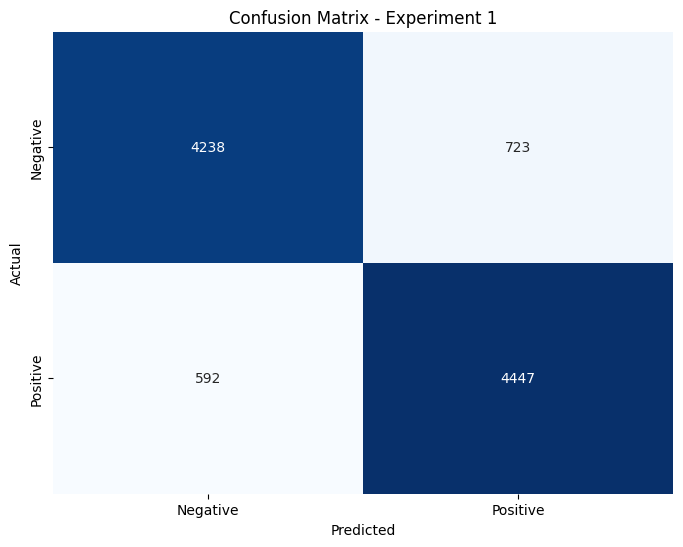

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


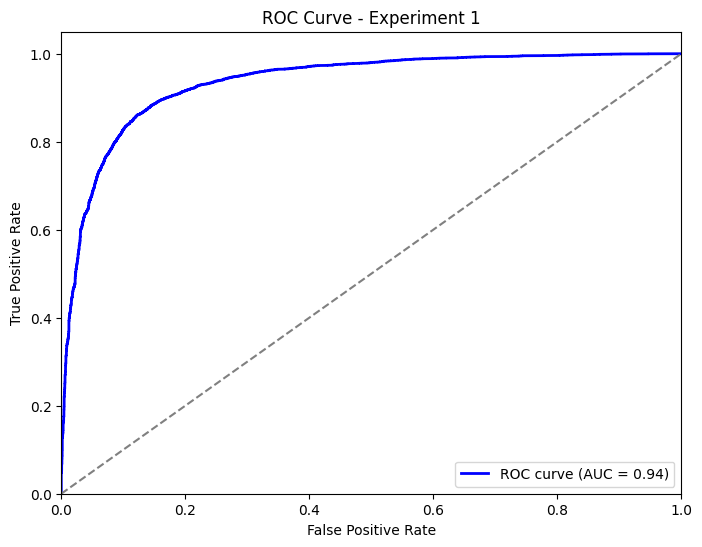

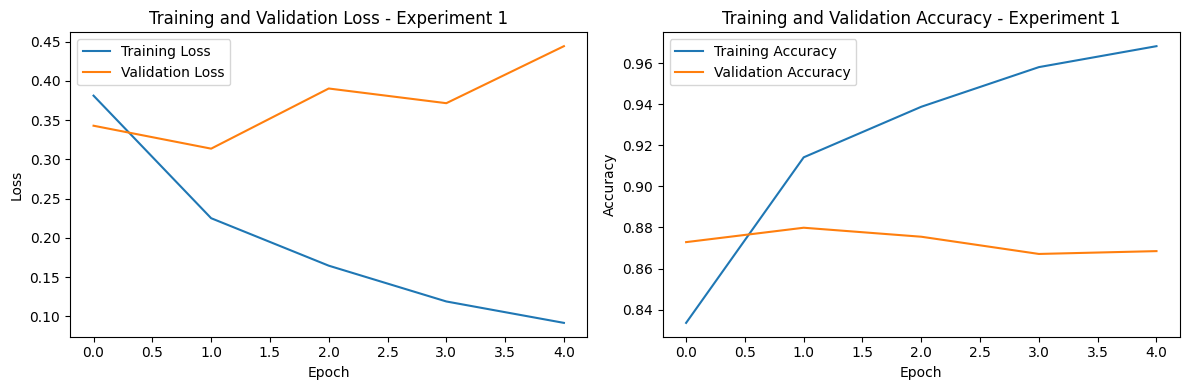

In [45]:
params_1 = {'embedding_dim': 50, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Adam'}
model_1 = build_lstm_model(params_1['embedding_dim'], params_1['lstm_units'], params_1['dropout_rate'], params_1['learning_rate'], params_1['optimizer'])
history_1 = model_1.fit(X_train_pad, y_train, batch_size=params_1['batch_size'], epochs=5, validation_split=0.2, verbose=1)
metrics_1 = evaluate_and_visualize(model_1, X_test_pad, y_test, history_1, params_1, 1)

## Run Experiment 2

Parameters: embedding_dim=100, lstm_units=64, dropout_rate=0.5, learning_rate=0.001, batch_size=64, optimizer=Adam

Epoch 1/5


/Users/samenergy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.7662 - loss: 0.4695 - val_accuracy: 0.8773 - val_loss: 0.2947
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.9178 - loss: 0.2155 - val_accuracy: 0.8816 - val_loss: 0.2942
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9456 - loss: 0.1524 - val_accuracy: 0.8754 - val_loss: 0.3585
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9639 - loss: 0.1030 - val_accuracy: 0.8751 - val_loss: 0.3856
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9706 - loss: 0.0833 - val_accuracy: 0.8716 - val_loss: 0.4219
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Experiment 2 Results:
   embedding_dim  lstm_units  dropout_rate  learning_rate  batch_size  \
0            100          64           0.5          0.001          64   

  optimizer  accuracy  precision    recall        f1  
0      Adam    0.8763   0.879593  0.874181  0.876879  


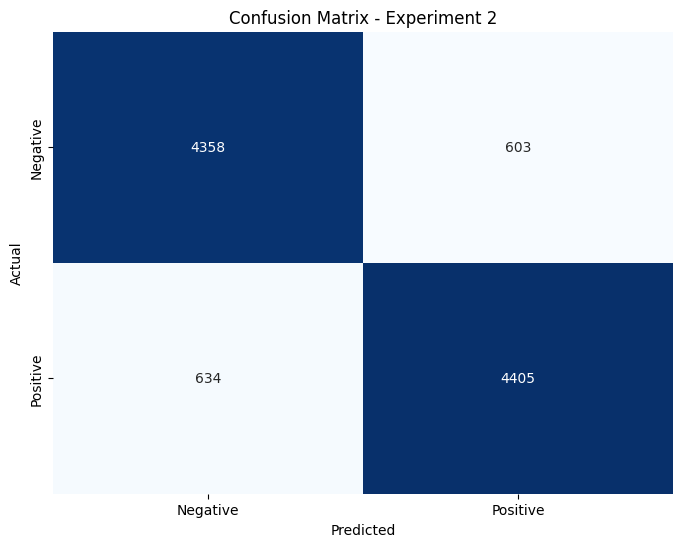

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


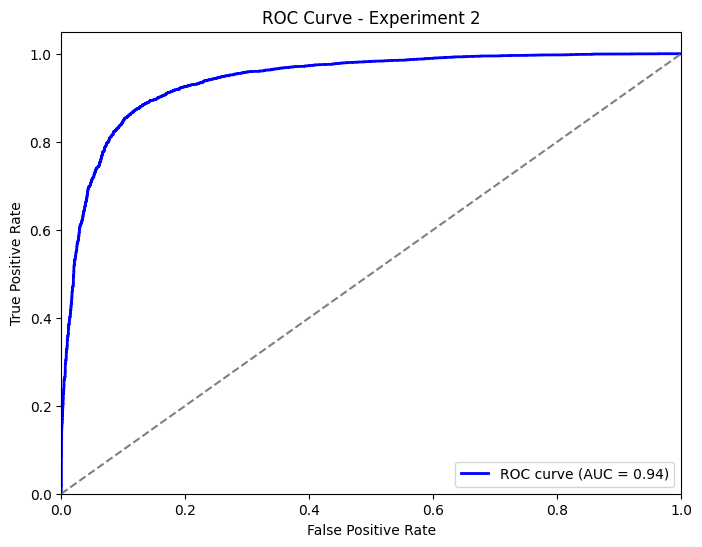

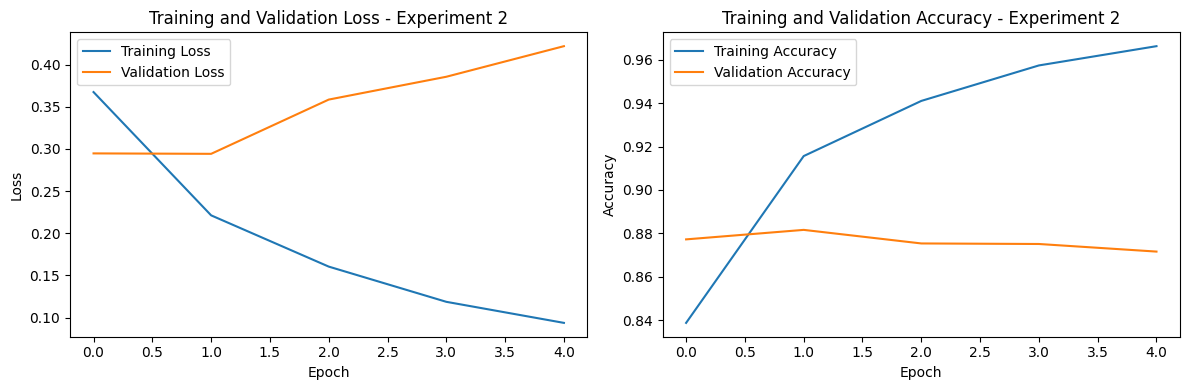

In [46]:
params_2 = {'embedding_dim': 100, 'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'optimizer': 'Adam'}
model_2 = build_lstm_model(params_2['embedding_dim'], params_2['lstm_units'], params_2['dropout_rate'], params_2['learning_rate'], params_2['optimizer'])
history_2 = model_2.fit(X_train_pad, y_train, batch_size=params_2['batch_size'], epochs=5, validation_split=0.2, verbose=1)
metrics_2 = evaluate_and_visualize(model_2, X_test_pad, y_test, history_2, params_2, 2)

## Run Experiment 3

Parameters: embedding_dim=100, lstm_units=128, dropout_rate=0.5, learning_rate=0.0005, batch_size=32, optimizer=Nadam

Epoch 1/5


/Users/samenergy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 53s 52ms/step - accuracy: 0.7660 - loss: 0.4563 - val_accuracy: 0.8850 - val_loss: 0.2847
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9235 - loss: 0.2097 - val_accuracy: 0.8850 - val_loss: 0.2901
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.9481 - loss: 0.1432 - val_accuracy: 0.8825 - val_loss: 0.3260
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.9631 - loss: 0.1078 - val_accuracy: 0.8733 - val_loss: 0.3569
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.9738 - loss: 0.0750 - val_accuracy: 0.8659 - val_loss: 0.4004
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step

Experiment 3 Results:
   embedding_dim  lstm_units  dropout_rate  learning_rate  batch_size  \
0            100         128           0.5         0.0005          32   

  optimizer  accuracy  precision    recall        f1  
0     Nadam    0.8659   0.879049  0.850962  0.864778  


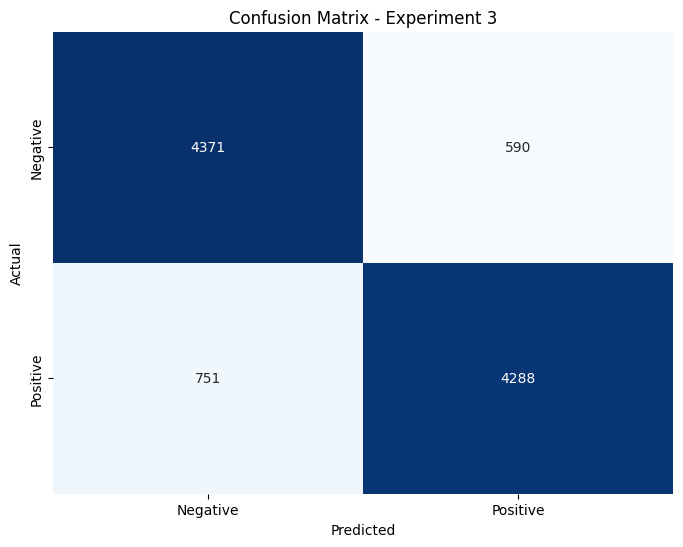

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


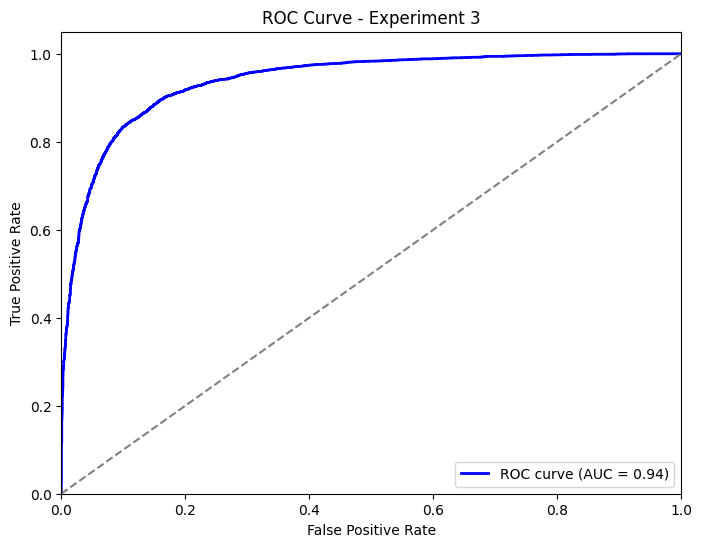

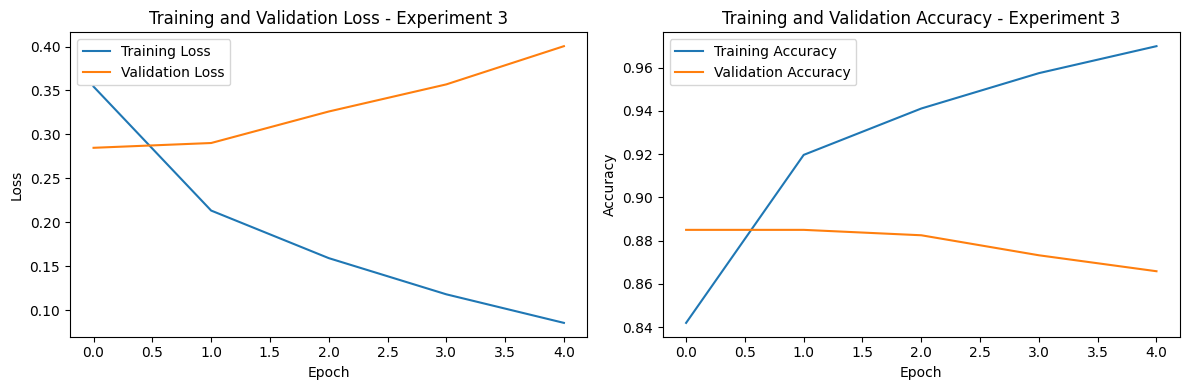

In [47]:
params_3 = {'embedding_dim': 100, 'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'optimizer': 'Nadam'}
model_3 = build_lstm_model(params_3['embedding_dim'], params_3['lstm_units'], params_3['dropout_rate'], params_3['learning_rate'], params_3['optimizer'])
history_3 = model_3.fit(X_train_pad, y_train, batch_size=params_3['batch_size'], epochs=5, validation_split=0.2, verbose=1)
metrics_3 = evaluate_and_visualize(model_3, X_test_pad, y_test, history_3, params_3, 3)

## Run Experiment 4

Parameters: embedding_dim=50, lstm_units=64, dropout_rate=0.3, learning_rate=0.001, batch_size=32, optimizer=Nadam

/Users/samenergy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.7882 - loss: 0.4400 - val_accuracy: 0.8889 - val_loss: 0.2789
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9221 - loss: 0.2063 - val_accuracy: 0.8815 - val_loss: 0.3023
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9470 - loss: 0.1466 - val_accuracy: 0.8723 - val_loss: 0.3190
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9645 - loss: 0.1046 - val_accuracy: 0.8723 - val_loss: 0.3747
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9710 - loss: 0.0857 - val_accuracy: 0.8581 - val_loss: 0.3996
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Experiment 4 Results:
   embedding_dim  lstm_units  dropout_rate  learning_rate  batch_size  \
0             50          64           0.3          0.001          32   

  optimizer  accuracy  precision   recall        f1  
0     Nadam    0.8631   0.895645  0.82437  0.858531  


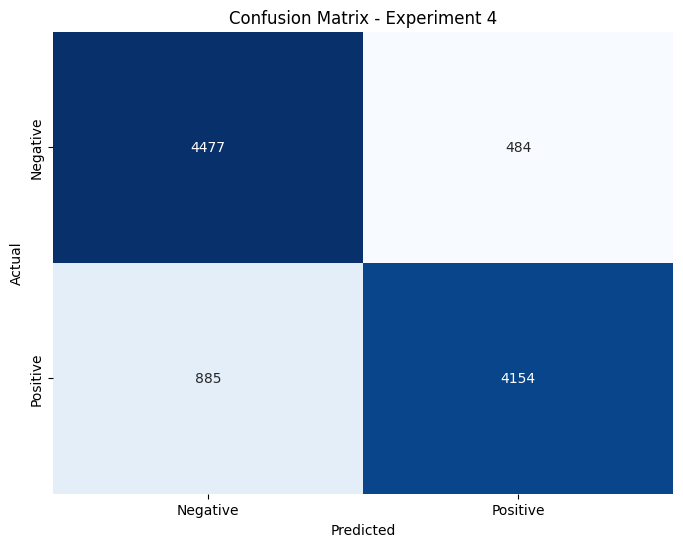

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


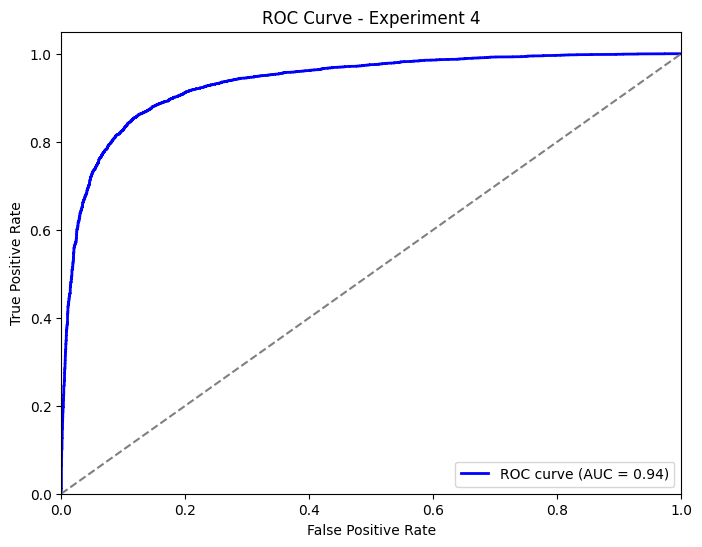

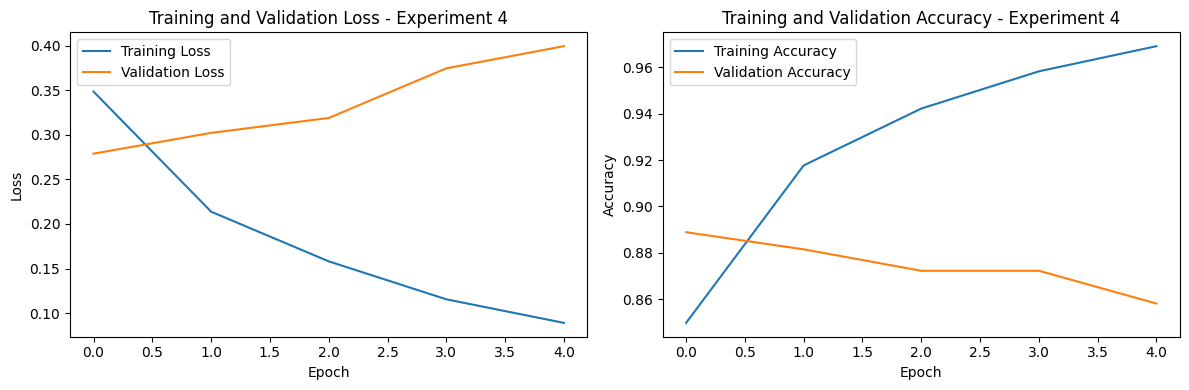

In [48]:
params_4 = {'embedding_dim': 50, 'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Nadam'}
model_4 = build_lstm_model(params_4['embedding_dim'], params_4['lstm_units'], params_4['dropout_rate'], params_4['learning_rate'], params_4['optimizer'])
history_4 = model_4.fit(X_train_pad, y_train, batch_size=params_4['batch_size'], epochs=5, validation_split=0.2, verbose=1)
metrics_4 = evaluate_and_visualize(model_4, X_test_pad, y_test, history_4, params_4, 4)

## Compare Experiments and Save Best Model

Combine results, identify the best model based on F1-score, and save it along with the tokenizer.

All LSTM Experiment Results:
   embedding_dim  lstm_units  dropout_rate  learning_rate  batch_size  \
0             50          64           0.3         0.0010          32   
1            100          64           0.5         0.0010          64   
2            100         128           0.5         0.0005          32   
3             50          64           0.3         0.0010          32   

  optimizer  accuracy  precision    recall        f1  
0      Adam    0.8685   0.860155  0.882516  0.871192  
1      Adam    0.8763   0.879593  0.874181  0.876879  
2     Nadam    0.8659   0.879049  0.850962  0.864778  
3     Nadam    0.8631   0.895645  0.824370  0.858531  


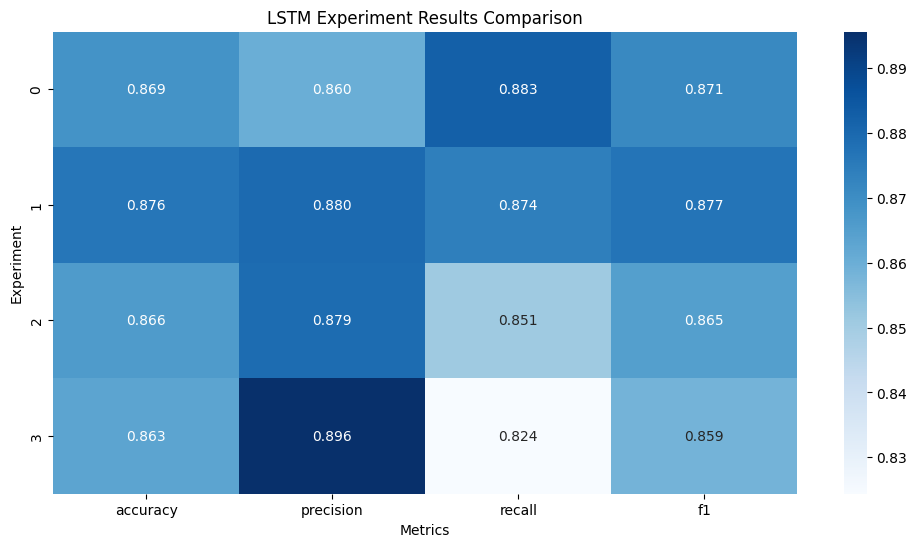

In [49]:
# Combine results
lstm_results = [metrics_1, metrics_2, metrics_3, metrics_4]
results_df = pd.DataFrame(lstm_results)

# Display combined results
print('All LSTM Experiment Results:')
print(results_df[['embedding_dim', 'lstm_units', 'dropout_rate', 'learning_rate', 'batch_size', 'optimizer', 'accuracy', 'precision', 'recall', 'f1']])

# Find best model
best_f1 = results_df['f1'].max()
best_idx = results_df['f1'].idxmax()
best_model = [model_1, model_2, model_3, model_4][best_idx]

# Save best model and tokenizer
save_model(best_model, 'best_lstm_model.keras')
joblib.dump(tokenizer, 'tokenizer.pkl')

# Visualize combined results
plt.figure(figsize=(12, 6))
sns.heatmap(results_df[['accuracy', 'precision', 'recall', 'f1']], annot=True, cmap='Blues', fmt='.3f')
plt.title('LSTM Experiment Results Comparison')
plt.xlabel('Metrics')
plt.ylabel('Experiment')
plt.show()

## Step 6: Prediction Function

Define a function to predict sentiment on new user input using the saved models.

In [50]:
def predict_sentiment(text, logistic_model, vectorizer, lstm_model, tokenizer, max_len=200):
    # Clean input text
    cleaned_text = clean_text(text)
    
    # Logistic Regression prediction
    text_vec = vectorizer.transform([cleaned_text])
    logistic_pred = logistic_model.predict(text_vec)[0]
    logistic_label = 'Positive' if logistic_pred == 1 else 'Negative'
    logistic_conf = logistic_model.predict_proba(text_vec)[0][logistic_pred]
    
    # LSTM prediction
    text_seq = tokenizer.texts_to_sequences([cleaned_text])
    text_pad = pad_sequences(text_seq, maxlen=max_len)
    lstm_pred = lstm_model.predict(text_pad, verbose=0)[0][0]
    lstm_label = 'Positive' if lstm_pred > 0.5 else 'Negative'
    lstm_conf = lstm_pred if lstm_pred > 0.5 else 1 - lstm_pred
    
    return {
        'logistic_prediction': logistic_label,
        'logistic_confidence': logistic_conf,
        'lstm_prediction': lstm_label,
        'lstm_confidence': lstm_conf
    }

## Step 7: Test Prediction

Test the prediction function with a sample input.

In [51]:
# Test prediction
sample_text = "This movie was absolutely fantastic, with great acting and a compelling story!"
prediction = predict_sentiment(sample_text, best_logistic_model, best_vectorizer, best_lstm_model, tokenizer)
print('Sample Prediction:')
print(f'Input: {sample_text}')
print(f'Logistic Regression: {prediction["logistic_prediction"]} (Confidence: {prediction["logistic_confidence"]:.4f})')
print(f'LSTM: {prediction["lstm_prediction"]} (Confidence: {prediction["lstm_confidence"]:.4f})')

Sample Prediction:
Input: This movie was absolutely fantastic, with great acting and a compelling story!
Logistic Regression: Positive (Confidence: 0.9568)
LSTM: Positive (Confidence: 0.9388)


## Step 8: How to Use Saved Models

To make predictions on new data, load the saved models and components:

In [14]:
from tensorflow.keras.models import load_model
import joblib

# Load saved models
logistic_model = joblib.load('/Users/samenergy/Documents/Projects/alu-ml_tech1-assignment/notebooks/models/best_logistic_model.pkl')
vectorizer = joblib.load('/Users/samenergy/Documents/Projects/alu-ml_tech1-assignment/notebooks/models/vectorizer.pkl')
lstm_model = load_model('/Users/samenergy/Documents/Projects/alu-ml_tech1-assignment/notebooks/models/best_lstm_model.keras')
tokenizer = joblib.load('/Users/samenergy/Documents/Projects/alu-ml_tech1-assignment/notebooks/models/tokenizer.pkl')

# Predict on new text
new_text = "The plot was not good."
result = predict_sentiment(new_text, logistic_model, vectorizer, lstm_model, tokenizer)
print(result)

{'logistic_prediction': 'Negative', 'logistic_confidence': np.float64(0.6476347683427552), 'lstm_prediction': 'Negative', 'lstm_confidence': np.float32(0.67827225)}
